# **ASSIGNMENT 2**

In [30]:
from google.colab import drive
drive.mount('/content/gdrive')
root_path = 'gdrive/My Drive/NLP_ASS2/'

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


Using Pytorch 

In [65]:
import pandas as pd
import numpy as np
import re
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import random
from tqdm.notebook import tqdm

In [66]:
df = pd.read_pickle(root_path+'en_hi.pkl')
df.head()

,english,hindi
57382,Who is this man?\n,-ये आदमी कौन है ?\n
28149,And the other brother?\n,और दूसरे भाई?\n
80284,"- Greetings, Mustakeen bhai.\n","नमस्ते, Mustakeen भाई।\n"
63596,"Please, reason with them.\n","कृपया, उन लोगों के साथ कारण.\n"
9459,There's a howling gale.\n,तेज़ हवा आ रही है।\n


# Divide into 9:1 train test split

In [67]:
df = df.iloc[:9000,:]
df.head()

,english,hindi
57382,Who is this man?\n,-ये आदमी कौन है ?\n
28149,And the other brother?\n,और दूसरे भाई?\n
80284,"- Greetings, Mustakeen bhai.\n","नमस्ते, Mustakeen भाई।\n"
63596,"Please, reason with them.\n","कृपया, उन लोगों के साथ कारण.\n"
9459,There's a howling gale.\n,तेज़ हवा आ रही है।\n


# DATA CLEANING

In [68]:
def cleanerEng(x):
  x = str(x)
  x = x.lower()
  x = re.sub(r'[^a-z0-9]+',' ',x)
  return x

def cleanerHindi(x):
  x = str(x)
  x = re.sub(r'[-.।|,?;:<>&$₹]+',' ',x)
  return x

def addTokens(x,start=False):
  x.append('<END>')
  if start:
    x.insert(0,'<START>')
  return list(x)
  

In [69]:
df.iloc[:,0] = df['english'].apply(func=cleanerEng)
df.iloc[:,1] = df['hindi'].apply(func= cleanerHindi)
df.iloc[:,0] = df['english'].apply(func= lambda x : (str(x).split()))
df.iloc[:,1] = df['hindi'].apply(func= lambda x : (str(x).split()))
df.iloc[:,0] = df['english'].apply(func= addTokens,start=False)
df.iloc[:,1] = df['hindi'].apply(func= addTokens,start=True)

In [71]:
data = df.values

# CONVERTING TO ONE HOT ENCODING

In [72]:
class vocab:

  def __init__(self,data,token=True):
    self.data = data
    if token:
      self.word2idx = {'<START>':1, '<END>':2, '<PAD>':0}
      self.idx2word = {1:'<START>', 2:'<END>', 0:'<PAD>'}
      self.idx = 2

    else:
      self.word2idx = {'<PAD>':0, '<END>':1}
      self.idx2word = {0:'<PAD>', 1:'<END>'}
      self.idx = 1

    self.x = []
    self.create()
    self.vocab_size = self.idx + 1

  def create(self):
    max_len = 0;
    for sentence in  self.data:
      max_len = max(max_len, len(sentence))
      for word in sentence:
        if self.word2idx.get(word) is None:
          self.idx += 1
          self.word2idx[word] = self.idx
          self.idx2word[self.idx] = word
    
    for sentence in self.data:
      sent = []
      for word in sentence:
        sent.append(self.word2idx[word])
      
      for i in range(len(sentence),max_len+1):
        sent.append(0)
      
      self.x.append(torch.Tensor(sent))

    

In [73]:
English_vocab = vocab(data[:,0],token=False)
Hindi_vocab = vocab(data[:,1],token=True)

In [74]:
class Data2tensor(Dataset):

  def __init__(self):
    self.x = English_vocab.x
    self.y = Hindi_vocab.x
  def __getitem__(self,i):
    return self.x[i], self.y[i]
  def __len__(self):
    return len(self.x)

dataset = Data2tensor()

# **SEQ2SEQ ATTENTION MODEL**

In [75]:
class encoder(nn.Module):

  def __init__(self, input_size, embedding_size, hidden_size, layers, bidirectional):
    '''
    input_size = size of vocab
    embedding_size = embedding dim
    hidden_size = hidden state size
    layer = num of layers of lstms
    '''

    # The embedding layer is created using nn.Embedding, the LSTM with nn.LSTM
    super().__init__()
    # input_dim is the size/dimensionality of the one-hot vectors that will be input to the encoder. This is equal to the input (source) vocabulary size.
    # emb_dim is the dimensionality of the embedding layer. This layer converts the one-hot vectors into dense vectors with emb_dim dimensions.
    # hidden_size is the dimensionality of the hidden and cell states.
    # layers is the number of layers in the RNN.
    self.embed = nn.Embedding(num_embeddings=input_size, embedding_dim=embedding_size) # output size = (*,embedding_size)
    self.lstm = nn.LSTM(input_size=embedding_size, hidden_size= hidden_size, num_layers=layers, batch_first = True, bidirectional = bidirectional)
    self.bidirectional = bidirectional
    #in order to convert bidirectional hidden state to unidirectional if LSTM is bidirectional
    # We can just think of $c_t$ as another type of hidden state. 
    # Similar to $h_0^l$, $c_0^l$ will be initialized to a tensor of all zeros. 
    # Also, our context vector will now be both the final hidden state and the final cell state, i.e. $z^l = (h_T^l, c_T^l)$. 
    self.fc_hidden = nn.Linear(hidden_size*2, hidden_size)
    self.fc_cell = nn.Linear(hidden_size*2, hidden_size)

  def forward(self,x):
    '''
    x shape = [batch_size, sentence]
    one complete sentence represents a "sequence"
    '''
    x = self.embed(x) # shape [batch_size,  sentence, embed_size]
    output, (hidden_state, cell_state) = self.lstm(x) #shape [batch_size, seq_len, num_directions(2)*hidden_size]

    if self.bidirectional:  #since we have 2 directions so add(concat) hidden of both directions into one
      hidden = torch.cat((hidden_state[0:1], hidden_state[1:2]), dim=2)
      cell = torch.cat((cell_state[0:1], cell_state[1:2]), dim = 2) #output [1(layer), batch, hidden_size*2]
      hidden_state = self.fc_hidden(hidden)
      cell_state = self.fc_cell(cell)

    # print(output.shape, x.shape)
    #output shape = [batch_size, seq_len, 2*hidden_size] 
    #hidden shape =[1(layers), batch_size, hidden_size]
    #  RNN returns: outputs (the top-layer hidden state for each time-step), 
    # hidden (the final hidden state for each layer, $h_T$, stacked on top of each other) 
    # and cell (the final cell state for each layer, $c_T$, stacked on top of each other).
    return output, hidden_state, cell_state

class AttnDecoder(nn.Module):
  def __init__(self, input_size, embedding_size, hidden_size, layers):
    super().__init__()

    self.embed = nn.Embedding(num_embeddings=input_size, embedding_dim=embedding_size) # output size = (*,embedding_size)
    self.lstm = nn.LSTM(input_size=hidden_size*2 + embedding_size, hidden_size= hidden_size, num_layers=layers, batch_first = True)
    self.fc = nn.Linear(in_features=hidden_size, out_features=input_size) #since output would be prob distribution among hindi vocab therefore out_feature=input_size
    #encoder_states from encoder => [batch, seq_len(11), 2*hidden_size]
    #prev decoder hidden_state => [batch, layers(1)*directions(2), hidden_size] =>need to be in => [batch, seq(31), hidden_size]
    #therefore input of energy will be along hidden_size ie input = hidden_size*2

    # This will take in the previous hidden state of the decoder, $s_{t-1}$, 
    # and all of the stacked forward and backward hidden states from the encoder, 
    # $H$. The layer will output an attention vector, $a_t$, that is the length of the source sentence, 
    # each element is between 0 and 1 and the entire vector sums to 1.
    # 1 for biasing

    self.energy =  nn.Linear(hidden_size*3, 1) #out [batch, seq_len, 1] (2 hidden state from bidirectional encoder and 1 from prev decoder hidden state => 1+2= 3 hidden states as input)
    self.softmax = nn.Softmax(dim=1)# doing softmax for each word ie (dim=1)

  
  def forward(self, x, hidden_state, cell_state, encoder_states):
    # print(encoder_states.shape)
    seq_len = encoder_states.shape[1]
    batch_size = encoder_states.shape[0]
    hidden_size = encoder_states.shape[2]

    h_new = hidden_state.repeat(seq_len, 1, 1) #shape [seq_len*1, batch, hidden_size*2(bidirectional)] it will repeat dim=0 seq length times
    #by doing .repeat operation we can concat hidden state with all timestamps of encoder_states
    # print(h_new.shape, encoder_states.shape, hidden_state.shape)
    h_new = h_new.permute(1,0,2) #[batch, seq_len, hidden_size*2]
    
    # we calculate the energy between the previous decoder hidden state and the encoder hidden states. 
    # As our encoder hidden states are a sequence of $T$ tensors, and our previous decoder hidden state is a single tensor, 
    # the first thing we do is repeat the previous decoder hidden state $T$ times. We then calculate the energy, $E_t$, 
    # between them by concatenating them together and passing them through a linear layer (attn) and a $\tanh$ activation function.

    energy = self.energy(torch.cat((h_new, encoder_states), dim=2))#input [batch, seq_len(11), hidden_size*3]  out = [batch, seq_len(31), 1]

    # Finally, we ensure the attention vector fits the constraints of having all elements between 0 and 1 
    # and the vector summing to 1 by passing it through a softmax layer.
    # This gives us the attention over the source sentence!
    att_weights = self.softmax(energy)
    # rearrannging dimensions
    att_weights = att_weights.permute(0,2,1) # [batch, 1, seq_len]

    context = torch.bmm(att_weights, encoder_states) #[batch, 1, hidden_size*2]
    x = x.reshape(-1,1) # shape [batch, 1]
    x = self.embed(x) # shape [batch, 1, embed_dim]
    input_new = torch.cat((context, x), dim=2) #[batch, 1, hidden_size*2 +embed_dim]
    # We then pass the hidden state from the top layer of the RNN, $s_t^L$, through a linear layer, 
    # $f$, to make a prediction of what the next token in the target (output) sequence should be, $\hat{y}_{t+1}$.
    output, (hidden_state, cell_state) = self.lstm(input_new, (hidden_state, cell_state)) # shape output=>[batch, 1, hidden_size], hidden=>[layers, batch, hidden_size]
    output = self.fc(output) # shape [batch, 1, hindi_vocab_size]

    output = output.squeeze(dim=1) #shape [batch, hindi_vocab_size]
    del h_new
    del context
    del input_new
    return output, hidden_state, cell_state

#Briefly going over all of the steps:
# the outputs tensor is created to hold all predictions, y hat
# the source sequence, X, is fed into the encoder to receive z and H
# the initial decoder hidden state is set to be the context vector, $s_0 = z = h_T$
# we use a batch of <sos> tokens as the first input, $y_1$
# we then decode within a loop:
# inserting the input token $y_t$, previous hidden state, $s_{t-1}$, and all encoder outputs, $H$, into the decoder
# receiving a prediction, $\hat{y}_{t+1}$, and a new hidden state, $s_t$
# we then decide if we are going to teacher force or not, setting the next input as appropriate


## Pass the input through the encoder which return encoder output and the encoder hidden state.
# The encoder output, encoder hidden state and the decoder input (which is the start token) is passed to the decoder.
# The decoder returns the predictions and the decoder hidden state.
# The decoder hidden state is then passed back into the model and the predictions are used to calculate the loss.
# Use teacher forcing to decide the next input to the decoder.
# Teacher forcing is the technique where the target word is passed as the next input to the decoder.
# The final step is to calculate the gradients and apply it to the optimizer and backpropagate.
class Attnseq2seq(nn.Module):
  def __init__(self, encoder, att_decoder):
    super().__init__()
    self.encoder = encoder
    self.decoder = att_decoder
  def forward(self, input, target, teaching_force=0.5):
    '''
    input = batch of english sentences[batch, sentece(padded)]
    target = batch of hindi sentences [batch, sentence(padded)] 
    '''
    batch_size = input.shape[0]
    seq_len = target.shape[1]
    hindi_vocab_size = Hindi_vocab.vocab_size

    output = torch.zeros((seq_len, batch_size, hindi_vocab_size)).to(device)

    encoder_states, hidden, cell = self.encoder(input)
    target = target.permute(1,0) # shape [seq, batch]
    x = target[0] # <START> token
    for i in range(1, seq_len):
      out, hidden, cell = self.decoder(x, hidden, cell, encoder_states) #out shape = [batch, vocab_size]
      output[i] = out
      decoder_guess = out.argmax(1)# taking the word with max value(confidence)  shape = [batch of words]
      if random.random() < teaching_force:
        x = target[i]
      else:
        x =  decoder_guess
    return output  #shape[seq_len, batch_size, vocab_size]



DEFINING PARAMETERS

In [76]:
##training
epochs = 60
learning_rate = 0.001
batch_size = 100
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
embedding_size = 256
hidden_size = 256
layers = 1
bidirection = True


In [78]:
loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
it = iter(loader)
x,y = next(it)
print(x.shape,y.shape)
len(dataset)


torch.Size([100, 11]) torch.Size([100, 31])


9000

In [79]:
ENC = encoder(English_vocab.vocab_size, embedding_size, hidden_size, layers, bidirection).to(device)
DE = AttnDecoder(Hindi_vocab.vocab_size, embedding_size, hidden_size, layers).to(device)

model = Attnseq2seq(ENC,DE).to(device)
optimizer = optim.Adam(model.parameters(),lr=learning_rate)
criterion = nn.CrossEntropyLoss(ignore_index=0)

# Next, we define our loss function. 
# The CrossEntropyLoss function calculates both the log softmax as well as the negative log-likelihood of our predictions.
# Our loss function calculates the average loss per token 

In [80]:
# Pass the input through the encoder which return encoder output and the encoder hidden state.
# The encoder output, encoder hidden state and the decoder input (which is the start token) is passed to the decoder.
# The decoder returns the predictions and the decoder hidden state.
# The decoder hidden state is then passed back into the model and the predictions are used to calculate the loss.
# Use teacher forcing to decide the next input to the decoder.
# Teacher forcing is the technique where the target word is passed as the next input to the decoder.
# The final step is to calculate the gradients and apply it to the optimizer and backpropagate.
train_loss = []
for epoch in tqdm(range(epochs)):
  for id,(x,y) in (enumerate(tqdm(loader))):
    x = x.long().to(device)
    y = y.long().to(device)#[batch,seq]

    output = model(x,y,1)# [seq, batch, vocab]
    output = output[1:].reshape(-1,output.shape[2])
    y = y.permute(1,0)#[seq, batch]
    y = y[1:].reshape(-1)

    optimizer.zero_grad()
    loss = criterion(output,y)

    loss.backward()
    optimizer.step()

    # if id%20 == 0:
  print(f'[{epoch+1}/{epochs}] loss=>{loss.item()}')
  train_loss.append(loss.item())

  


[1/60] loss=>5.329582691192627



[2/60] loss=>4.958299160003662



[3/60] loss=>4.5113301277160645



[4/60] loss=>4.021283149719238



[5/60] loss=>4.1346435546875



[6/60] loss=>3.662659168243408



[7/60] loss=>3.2355499267578125



[8/60] loss=>2.832834243774414



[9/60] loss=>2.712728261947632



[10/60] loss=>2.500666379928589



[11/60] loss=>2.2538375854492188



[12/60] loss=>1.9992976188659668



[13/60] loss=>1.8002955913543701



[14/60] loss=>1.6665964126586914



[15/60] loss=>1.3260722160339355



[16/60] loss=>1.0955829620361328



[17/60] loss=>1.0429664850234985



[18/60] loss=>0.8562750220298767



[19/60] loss=>0.7657190561294556



[20/60] loss=>0.5849363803863525



[21/60] loss=>0.4894269108772278



[22/60] loss=>0.4047882556915283



[23/60] loss=>0.29637059569358826



[24/60] loss=>0.28066056966781616



[25/60] loss=>0.24603651463985443



[26/60] loss=>0.22050930559635162



[27/60] loss=>0.17912138998508453



[28/60] loss=>0.1583075225353241



[29/60] loss=>0.13465191423892975



[30/60] loss=>0.11448463052511215



[31/60] loss=>0.09337864816188812



[32/60] loss=>0.09724827110767365



[33/60] loss=>0.09380612522363663



[34/60] loss=>0.08316928893327713



[35/60] loss=>0.0706617534160614



[36/60] loss=>0.0694589912891388



[37/60] loss=>0.055498380213975906



[38/60] loss=>0.06618314981460571



[39/60] loss=>0.03450068458914757



[40/60] loss=>0.055978674441576004



[41/60] loss=>0.05126567184925079



[42/60] loss=>0.05573194846510887



[43/60] loss=>0.05146998167037964



[44/60] loss=>0.0660516619682312



[45/60] loss=>0.041214779019355774



[46/60] loss=>0.07605984807014465



[47/60] loss=>0.19321851432323456



[48/60] loss=>0.16427387297153473



[49/60] loss=>0.11494716256856918



[50/60] loss=>0.07362400740385056



[51/60] loss=>0.03064088337123394



[52/60] loss=>0.041592516005039215



[53/60] loss=>0.020459845662117004



[54/60] loss=>0.035924021154642105



[55/60] loss=>0.02297678217291832



[56/60] loss=>0.022106366232037544



[57/60] loss=>0.02382495254278183



[58/60] loss=>0.028946509584784508



[59/60] loss=>0.027293793857097626



[60/60] loss=>0.024375276640057564



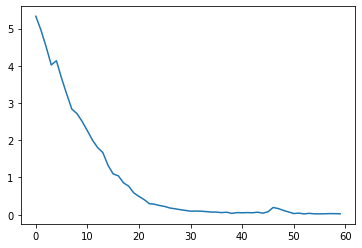

In [81]:
import matplotlib.pyplot as plt
plt.plot(train_loss)
plt.show()

# CHECKPOINT 
After Training and building model

In [ ]:
torch.save(model.state_dict(),'model.pt')
from google.colab import files
files.download('model.pt')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [83]:
def prediction(x):
    for idx in x:
      if idx == 0:
        break
      print(English_vocab.idx2word[int(idx)],end=' ')
    x = x.long().reshape(1,-1).to(device)
    ans = translate(x)
    res = []
    for id in ans:
      res.append(Hindi_vocab.idx2word[id])
    return res

# The evaluate function is similar to the training loop, 
# except we don't use teacher forcing here. 
# The input to the decoder at each time step is its previous predictions along with the hidden state and the encoder output.
# Stop predicting when the model predicts the end token.
# And store the attention weights for every time step.

def translate(input):
      #input = batch of english sentences[batch, sentece(padded)]
      with torch.no_grad():
        guess = []
        encoder_states, hidden, cell = model.encoder(input)
        # x = torch.ones((1)).float().to(device) # <START> token
        x = torch.ones((1)).long().to(device)
        while True:
          out, hidden, cell = model.decoder(x, hidden, cell, encoder_states) #out shape = [batch, vocab_size]
          x = out.argmax(1)# taking the word with max value(confidence)  shape = [batch of words]
          guess.append(int(x[0].detach().cpu()))
          if x == 2:
            break

      return guess

In [90]:
def get(sent):
  # sentence = sentence.lower()
  # sent = sentence.split()
  # sent.append('<END>')
  # print(sent)
  toks = []
  for word in sent:
    if English_vocab.word2idx.get(word) is None:
      toks.append(English_vocab.word2idx['the'])
    else:
      toks.append(English_vocab.word2idx[word])
  # print(toks)
  sent = torch.tensor(toks).float()
  res = prediction(sent)
  # print(res)
  return res


In [85]:
for i in range(50):
  print(prediction(dataset[random.randint(0,9000)][0]))
  print()

i want it sorted <END> ['मैंइसेहल', 'चाहते', '<END>']

mine s in the shop <END> ['खान', 'की', 'दुकान', 'में', 'है', '<END>']

mrs chow always wins that <END> ['श्रीमती', 'चाओ', 'हमेशा', 'जीत', 'जाती', 'हैं', '<END>']

what are those for <END> ['के', 'लिए', 'वो', 'क्या', 'है', '<END>']

you can t see anything <END> ['आप', 'कुछ', 'देख', 'नहीं', 'सकते', 'थे', '<END>']

hey i got a delivery <END> ['अरे', 'मैं', 'एक', 'प्रसव', 'हो', 'गया', '<END>']

it s crackles <END> ['आईटी', 'इस', '(Crackles)', '<END>']

well sure it is <END> ['हाँ', 'ये', 'है', '<END>']

babe it ll get there <END> ['बेबे', 'यह', 'वहाँ', 'मिल', 'जाएगा', '<END>']

apples don t cost a nickel <END> ['सेब', 'एक', 'निकेल', 'खर्च', 'नहीं', 'करते', '<END>']

you ll never get big <END> ['तुम', 'कभी', 'बड़े', 'नहीं', 'होगे', '<END>']

man speaking native language <END> ['पुरुष', 'अपनी', 'मातृभाषा', 'में', 'बोल', 'रहा', 'है', '<END>']

what difference does it make <END> ['क्या', 'फर्क', 'पड़ता', 'है', '<END>']

so you have some qu

In [ ]:
#bleu score calculation

In [86]:
tdf = pd.read_pickle(root_path+'en_hi.pkl')
tdf = tdf.iloc[9000:10000,:]
tdf.head()

,english,hindi
54238,Maman makes a good cookie.\n,मा आदमी एक अच्छा कुकी बनाता है.\n
42033,You want that drink now?\n,अब आप कि पीना चाहता हूँ?\n
6370,Andy would never do that.\n,एंडी ऐसा कभी नहीं करेगा.\n
43866,I finally asked him why.\n,मैं अंत में उसे क्यों कहा.\n
76132,He's such a nice boy.\n,उन्होंने कहा कि इस तरह एक अच्छा लड़का है।\n


In [88]:
tdf.iloc[:,0] = tdf['english'].apply(func=cleanerEng)
tdf.iloc[:,1] = tdf['hindi'].apply(func= cleanerHindi)
tdf.iloc[:,0] = tdf['english'].apply(func= lambda x : (str(x).split()))
tdf.iloc[:,1] = tdf['hindi'].apply(func= lambda x : (str(x).split()))
tdf.iloc[:,0] = tdf['english'].apply(func= addTokens,start=False)
print(tdf.head())
tdata = tdf.values
test_dataset = vocab(tdata[:,0],token=False)

                                      english                                              hindi
54238  [maman, makes, a, good, cookie, <END>]  [['मा', 'आदमी', 'एक', 'अच्छा', 'कुकी', 'बनाता'...
42033    [you, want, that, drink, now, <END>]       [['अब', 'आप', 'कि', 'पीना', 'चाहता', 'हूँ']]
6370    [andy, would, never, do, that, <END>]          [['एंडी', 'ऐसा', 'कभी', 'नहीं', 'करेगा']]
43866    [i, finally, asked, him, why, <END>]     [['मैं', 'अंत', 'में', 'उसे', 'क्यों', 'कहा']]
76132      [he, s, such, a, nice, boy, <END>]  [['उन्होंने', 'कहा', 'कि', 'इस', 'तरह', 'एक', ...


In [112]:
file1 = open(root_path+"test_output.txt","w")
for i in range(983):
  res = get(tdata[i,0])[:-1]
  print(res)
  file1.write(str(tdata[i,0][:-1])+"---->"+str(res)+"\n") 

file1.close()


maman makes a good cookie <END> ['छोटा', 'अच्छा', 'दफन', 'है']
you want that drink now <END> ['अब', 'आपको', 'एक', 'तरह', 'है', 'ना']
andy would never do that <END> ['तो', 'हम', 'नहीं', 'कर', 'सकते']
i finally asked him why <END> ['हां', '"तो', 'वरना', 'निमंत्रण', 'नहीं', 'सकते', 'हैं']
he s such a nice boy <END> ['वह', 'एक', 'अच्छा', 'लड़का']
hey come on wait up <END> ['और', 'क्या', 'कर', 'रहा', 'हूँ']
i don t have 60 grand <END> ['मैं', 'नहीं', 'मौसम', 'लग', 'रहा', 'है']
english us the <END> ['हमें', 'यात्रा', 'हमें', 'दिया']
what the hell was that <END> ['क्या', 'था', 'कि']
cooper we are the up <END> ['हम', 'पैसा', 'भी', 'कर', 'रहे', 'हैं']
i don t like no the <END> ['नहीं', 'पता', 'नहीं', 'है']
how dare you beat us <END> ['कैसे', 'हम', 'क्या']
tech the enter at the speed <END> ['तो', 'लड़के', 'को', 'क्या']
a sorceress from another the <END> ['एक', 'और', 'काम', 'आता', 'है']
if only it were possible <END> ['यह', 'केवल', 'गया']
i can handle the computer <END> ['मैं', 'सकता', 'हूँ']
i j

In [98]:
list_refrences = []
list_hypothesis = []
for i in tqdm(range(int(tdata.shape[0]/1.2))):
  list_refrences.append(tdata[i,0][:-1])
  list_hypothesis.append((get(tdata[i,0])[:-1]))

maman makes a good cookie <END> you want that drink now <END> andy would never do that <END> i finally asked him why <END> he s such a nice boy <END> hey come on wait up <END> i don t have 60 grand <END> english us the <END> what the hell was that <END> cooper we are the up <END> i don t like no the <END> how dare you beat us <END> tech the enter at the speed <END> a sorceress from another the <END> if only it were possible <END> i can handle the computer <END> i just saw your husband <END> boss we got a problem <END> you have my word <END> it s too hot my lady <END> you re not going to die <END> they ll hit us in force <END> you ll have to kill me <END> yeah you better walk on <END> all prisoners report for the <END> is this because of yesterday <END> you can t touch him the <END> i don t fucking believe you <END> sharmila are these your the <END> i do the thing <END> the count of monte the <END> they are the than the <END> waste the on a loser <END> that award was a sham <END> i m no

In [101]:
import nltk
print(f"bleu-1 : {nltk.translate.bleu_score.corpus_bleu(list_refrences, list_hypothesis, weights=(1.0,0.0,0.0,0.0))}")
print(f"bleu-2 : {nltk.translate.bleu_score.corpus_bleu(list_refrences, list_hypothesis, weights=(0.5,0.5,0.0))}")
print(f"bleu-3 : {nltk.translate.bleu_score.corpus_bleu(list_refrences, list_hypothesis, weights=(0.33,0.33,0.33,0.0))}")
print(f"bleu-4 : {nltk.translate.bleu_score.corpus_bleu(list_refrences, list_hypothesis, weights=(0.25,0.25,0.25,0.25))}")

/usr/local/lib/python3.6/dist-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 2-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)


bleu-1 : 0.00024894199651481183
bleu-2 : 0.015777895820254736
bleu-3 : 0.06467141979273375
bleu-4 : 0.12561009442021265
